<a href="https://colab.research.google.com/github/sgogoigh/Song-Recommendation-System/blob/main/Spotify_Song_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
!pip install WordCloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import json

In [69]:
kaggle_config = json.load(open("kaggle.json"))

In [70]:
kaggle_config.keys()

dict_keys(['username', 'key'])

In [71]:
import os
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

In [72]:
!kaggle datasets download notshrirang/spotify-million-song-dataset

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0
spotify-million-song-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [73]:
import zipfile
with zipfile.ZipFile('spotify-million-song-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [74]:
df = pd.read_csv("/content/spotify_millsongdata.csv")

In [75]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [76]:
df.columns

Index(['artist', 'song', 'link', 'text'], dtype='object')

In [77]:
df.shape

(57650, 4)

In [78]:
df.isnull().sum()

,0
artist,0
song,0
link,0
text,0


In [79]:
df.duplicated().sum()

np.int64(0)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [81]:
topArtists = df['artist'].value_counts().head(10)
topArtists

,count
artist,
Donna Summer,191
Gordon Lightfoot,189
Bob Dylan,188
George Strait,188
Alabama,187
Reba Mcentire,187
Cher,187
Loretta Lynn,187
Chaka Khan,186


In [82]:
# link is useless
df = df.drop('link', axis=1).reset_index(drop=True)

In [83]:
df.head()

,artist,song,text
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante","Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...


In [84]:
# WordCloud for song lyrics
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_lyrics)

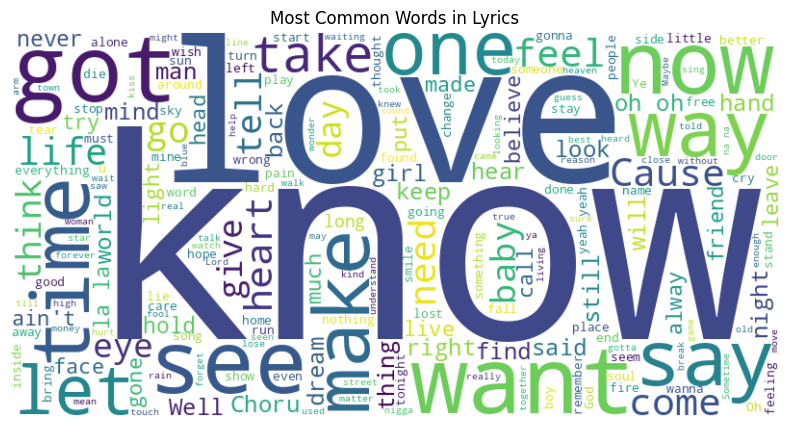

In [85]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Lyrics")
plt.show()

In [86]:
# download nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [87]:
stop_words = set(stopwords.words('english'))

In [88]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [89]:
df = df.sample(10000)
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [90]:
df.head()

,artist,song,text,cleaned_text
38023,John Denver,Looking For Space,"On the road of experience, I'm trying to find ...",road experience im trying find way sometimes w...
2341,Celine Dion,Loved Me Back To Life,I was walking stuck inside my head \r\nI coul...,walking stuck inside head couldnt get turn lig...
1985,Britney Spears,Luv The Hurt Away,"Yeah, yeah oh \r\n \r\nOh I was broken heart...",yeah yeah oh oh broken hearted feeling sad alo...
35507,Harry Belafonte,Those Three Are On My Mind,I think of Andy in the cold wet clay \r\nThos...,think andy cold wet clay three mind comrades b...
55108,Vince Gill,A River Like You,A good woman's love is like a river \r\nRunni...,good womans love like river runnin heart man g...


In [91]:
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [92]:
# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [93]:
def recommend_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    # Find the index of the song
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset!"
    idx = idx[0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Get song indices
    song_indices = [i[0] for i in sim_scores]

    # Return top n similar songs
    return df[['artist', 'song']].iloc[song_indices]

In [102]:
# sample song recommendation
recommendations = recommend_songs(df["song"].iloc[2]) # df["song"][2]
print(recommendations)

               artist            song
36444        Ice Cube          Wicked
48119   Peter Gabriel    Secret World
1278         Bee Gees     Blue Island
26448  Britney Spears  Especially For
33804  George Michael     Secret Love


In [104]:
# loading into pickle files
import logging
import joblib

joblib.dump(df, 'df_cleaned.pkl')
joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl')
joblib.dump(cosine_sim, 'cosine_sim.pkl')

['cosine_sim.pkl']